# Equação do Calor 2D

Vamos resolver numericamente a equação do calor a 2D:

\begin{align*}
\frac{\partial T}{\partial t} = D \left[\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2}\right]
\end{align*}

# Imports

In [19]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image
from typing import Callable

# Método FTCS

In [20]:
def calor2DFTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dtMult: float = 0.99):
    """
        Evolui a equação do calor por um tempo `T` com o método FTCS com condições iniciais `ci` evoluindo apenas os pontos onde `mask == True`.

        O coeficiente de difusão é `D` e o espaçamento entre pontos da grelha no espaço e no tempo é `dx`, `dy`. O intervalo de tempo usado é `dtMult` * (menor dt para o qual o método é estável)

        Assume que os pontos na fronteira de `mask` são `False` (assumimos que a temperatura na fronteira está fixa).
    """

    # Copiar condições iniciais
    now = np.copy(ci)
    nex = np.copy(ci)

    # Criar o passo no tempo
    dt = 1 / (2 * D * (1/dx**2 + 1/dy**2)) * dtMult
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Evoluir no tempo
    i = 0
    while i < iMax:
        nex[1:-1, 1:-1] = now[1:-1, 1:-1] + mask[1:-1, 1:-1] * (Fx * (now[1:-1, 2:] + now[1:-1, :-2] - 2 * now[1:-1, 1:-1]) +  Fy * (now[2:, 1:-1] + now[:-2, 1:-1] - 2 * now[1:-1, 1:-1]))
        
            
        i += 1
        now = np.copy(nex)
    
    return now, i * dt

# Método BTCS

Vamos usar este método com ordenação row-major:
\begin{align*}
ij \to N_xi + j
\end{align*}

In [21]:
def calor2DBTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dt: float):
    """
        Evolui a equação do calor por um tempo `T` com o método BTCS com condições iniciais `ci` evoluindo apenas os pontos onde `mask == True`.

        O coeficiente de difusão é `D` e o espaçamento entre pontos da grelha no espaço e no tempo é `dx`, `dy`. O intervalo de tempo usado é `dt`.
    """

    # Copiar condições iniciais
    Ny, Nx = ci.shape[0], ci.shape[1]
    cif = ci.flatten()
    now = np.copy(cif)
    nex = np.copy(cif)

    # Aplicar a máscara
    maskf = mask.flatten()

    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Construir a matriz de coeficientes
    pontos = len(now)
    aa = sp.sparse.diags_array([(1 + 2 * Fx + 2 * Fy), -Fx, -Fx, -Fy, -Fy], offsets=[0, -1, 1, -Nx, Nx], shape=(pontos, pontos))
    aa = sp.sparse.csc_matrix(aa)
    
    # Pré-fatorizar a matriz de coeficientes
    aaSolver = sp.sparse.linalg.factorized(aa)

    # Evoluir no tempo
    i = 0
    while i < iMax:
        nex = aaSolver(now)
        nex = maskf * nex + (1 - maskf) * cif
            
        i += 1
        now = np.copy(nex)
    
    now = np.reshape(now, (Ny, Nx))
    return now, i * dt

# Método CN
Vamos usar este método com ordenação row-major:
\begin{align*}
ij \to N_xi + j
\end{align*}

In [22]:
def calor2DCN(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dt: float):
    """
        Evolui a equação do calor por um tempo `T` com o método de Crank-Nicholson com condições iniciais `ci` evoluindo apenas os pontos onde `mask == True`.

        O coeficiente de difusão é `D` e o espaçamento entre pontos da grelha no espaço e no tempo é `dx`, `dy`. O intervalo de tempo usado é `dt`.
    """

    # Copiar condições iniciais
    Ny, Nx = ci.shape[0], ci.shape[1]
    cif = ci.flatten()
    now = np.copy(cif)
    nex = np.copy(cif)
    
    pontos = len(now)

    # Aplicar a máscara
    maskf = mask.flatten()

    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Construir a matriz de coeficientes A
    aa = sp.sparse.diags_array([1 + Fx + Fy, -Fx/2, -Fx/2, -Fy/2, -Fy/2], offsets=[0, -1, 1, -Nx, Nx], shape=(pontos, pontos))
    aa = sp.sparse.csc_matrix(aa)
    
    # Pré-fatorizar a matriz de coeficientes
    aaSolver = sp.sparse.linalg.factorized(aa)

    # Construir a matriz que permite obter o vetor do lado direito B
    bb = sp.sparse.diags_array([1 - Fx - Fy, Fx/2, Fx/2, Fy/2, Fy/2], offsets=[0, -1, 1, -Nx, Nx], shape=(pontos, pontos))
    
    # Evoluir no tempo
    i = 0
    while i < iMax:
        nex = aaSolver(bb @ now)
        nex = maskf * nex + (1 - maskf) * cif
            
        i += 1
        now = np.copy(nex)
    
    now = np.reshape(now, (Ny, Nx))
    return now, i * dt

# Método ADI
Vamos usar este método com ordenação row-major:
\begin{align*}
ij \to N_xi + j
\end{align*}

In [23]:
def calor2DADI(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dt: float):
    """
        Evolui a equação do calor por um tempo `T` com o método FTCS com condições iniciais `ci` evoluindo apenas os pontos onde `mask == True`.

        O coeficiente de difusão é `D` e o espaçamento entre pontos da grelha no espaço e no tempo é `dx`, `dy`. O intervalo de tempo usado é `dt`.
    """

    # Copiar condições iniciais
    Ny, Nx = ci.shape[0], ci.shape[1]
    cif = ci.flatten()
    now = np.copy(cif)
    nex = np.copy(cif)
    
    pontos = len(now)

    # Aplicar a máscara
    maskf = mask.flatten()
    
    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Construir a matriz de coeficientes do primeiro meio passo
    aa1 = sp.sparse.diags_array([1 + Fx, -Fx/2, -Fx/2,], offsets=[0, -1, 1], shape=(pontos, pontos))
    aa1 = sp.sparse.csc_matrix(aa1)
    aa1Solver = sp.sparse.linalg.factorized(aa1)

    bb1 = sp.sparse.diags_array([1 - Fy, Fy/2, Fy/2], offsets=[0, -Nx, Nx], shape=(pontos, pontos))


    # Repetir para o segundo meio passo
    aa2 = sp.sparse.diags_array([1 + Fy, -Fy/2, -Fy/2,], offsets=[0, -Nx, Nx], shape=(pontos, pontos))
    aa2 = sp.sparse.csc_matrix(aa2)
    aa2Solver = sp.sparse.linalg.factorized(aa2)

    bb2 = sp.sparse.diags_array([1 - Fx, Fx/2, Fx/2], offsets=[0, -1, 1], shape=(pontos, pontos))
    
    # Evoluir no tempo
    i = 0
    while i < iMax:
        nex1 = aa1Solver(bb1 @ now)
        nex = aa2Solver(bb2 @ nex1)
        nex = maskf * nex + (1 - maskf) * cif
            
        i += 1
        now = np.copy(nex)
    
    now = np.reshape(now, (Ny, Nx))
    return now, i * dt

# Testar

Vamos aquecer um leitão!

In [24]:
# Parâmetros do Problema (Unidades SI, Temperatura em Celsius)

# Dimensões e Temperatura do Forno
FORNOX = 0.60
FORNOY = 0.60
FORNOT = 150

# Dimensões e Temperatura do Leitão
LEITAOX = 0.45
LEITAOTI = 6
LEITAOTF = 70

# Coeficiente de difusão
DIF = 1.45e-7


# Parâmetros da Simulação

# Número de pontos a usar
NX = 601
NY = 601

# Espaçamento entre pontos da grelha
DX = FORNOX / (NX-1)
DY = FORNOY / (NY-1)

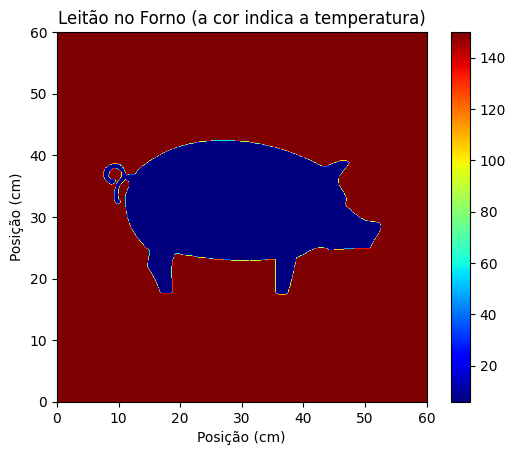

In [25]:
# Importar a imagem
leitao = Image.open("leitao_bw.png")

# Tamanho da imagem
XMAX, YMAX = leitao.size
LEITAOY = LEITAOX * (YMAX / XMAX)

# Espaçamento entre pontos da grelha da imagem do leitão
NXLEITAO = int(LEITAOX / FORNOX * NX)
NYLEITAO = int(LEITAOY / FORNOY * NY)

DXLEITAO = LEITAOX / (NXLEITAO - 1)
DYLEITAO = LEITAOY / (NYLEITAO - 1)

# Transformar em array
ll = np.array(leitao)

# Posicionamos o leitão de forma a que fique no centro do forno
NXI = (NX - NXLEITAO) // 2
NYI = (NY - NYLEITAO) // 2

XI = NXI * DX
YI = NYI * DY

# Interpolar a imagem png para obter a resolução desejada
xx = np.arange(XMAX)
yy = np.arange(YMAX)
coords = []

MULTX = DXLEITAO * NXLEITAO / XMAX
MULTY = DYLEITAO * NYLEITAO / YMAX
for i in range(XMAX):
    for j in range(YMAX):
        coords += [(XI + i * MULTX, YI + j * MULTY)]

interpol = sp.interpolate.LinearNDInterpolator(coords, ll.flatten(order="F"), fill_value=0)

# Colocar o leitão dentro do forno e definir a grelha
xx = np.linspace(0, FORNOX, NX)
yy = np.linspace(0, FORNOY, NY)
mx, my = np.meshgrid(xx, yy)
ll = interpol(mx, my)

# Fazer a máscara que indica onde está o leitão
leitao = ll > 240

# Aplicar as condições iniciais (que incluem as condições fronteira graças a máscara que criamos)
forno = np.zeros_like(ll)
forno[:, :] = FORNOT
forno[leitao] = LEITAOTI

# Ver a imagem
plt.imshow(forno, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title("Leitão no Forno (a cor indica a temperatura)")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

## Método FTCS

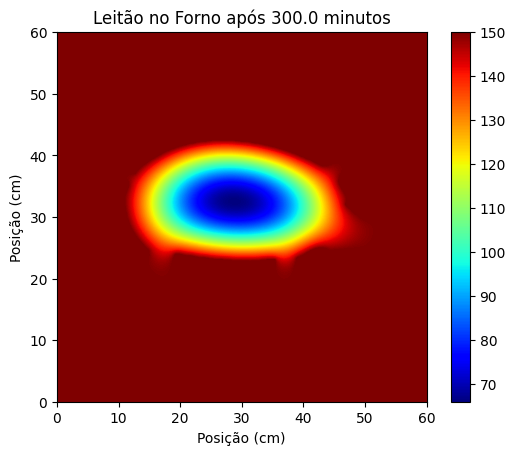

In [26]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = calor2DFTCS(5 * 3600, fornoC, leitaoC, DIF, DX, DY)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

## Método BTCS

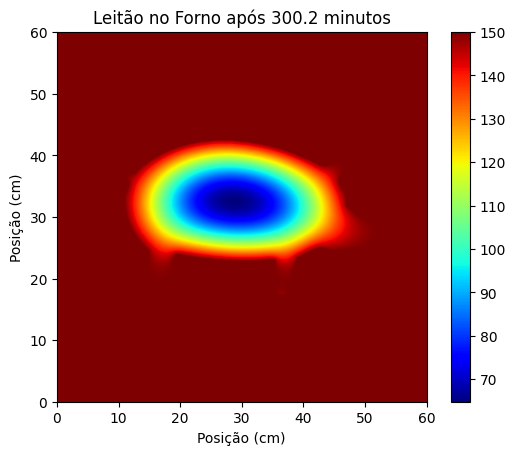

In [27]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = calor2DBTCS(5 * 3600, fornoC, leitaoC, DIF, DX, DY, 10)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

## Método CN

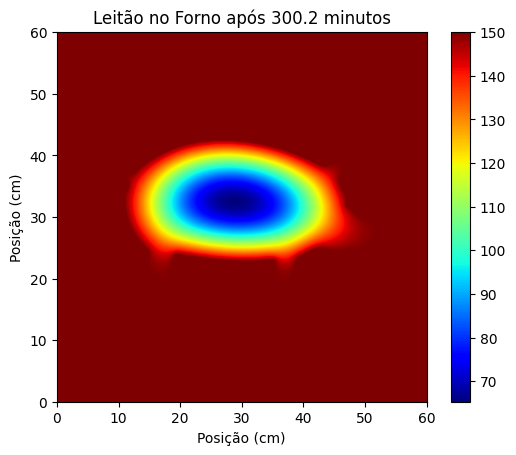

In [28]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = calor2DCN(5 * 3600, fornoC, leitaoC, DIF, DX, DY, 10)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

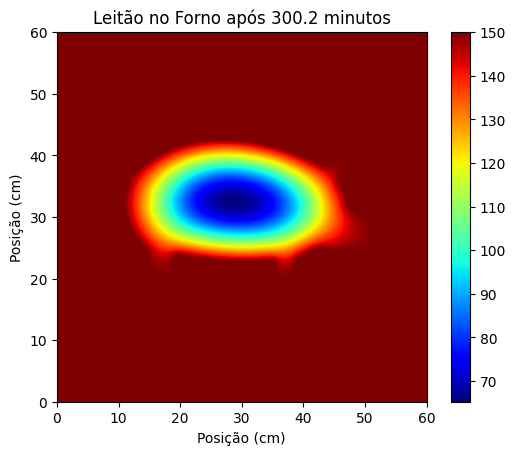

In [29]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = calor2DADI(5 * 3600, fornoC, leitaoC, DIF, DX, DY, 10)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()